In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing import image_dataset_from_directory
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns


2025-07-30 14:32:28.488350: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753885948.859254      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753885948.962678      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [5]:
# Path to dataset
dataset_path = '/kaggle/input/bd-medicinal-plant/Medicinal Plant BD'


In [6]:


# Set dataset path
dataset_path = '/kaggle/input/bd-medicinal-plant/Medicinal Plant BD'
image_size = (224, 224)
batch_size = 32
seed = 123

# Load 70% training
train_ds_raw = tf.keras.utils.image_dataset_from_directory(
    dataset_path,
    validation_split=0.3,
    subset="training",
    seed=seed,
    image_size=image_size,
    batch_size=batch_size
)

# Load 30% validation + test
val_test_ds_raw = tf.keras.utils.image_dataset_from_directory(
    dataset_path,
    validation_split=0.3,
    subset="validation",
    seed=seed,
    image_size=image_size,
    batch_size=batch_size
)

# Save class names
class_names = train_ds_raw.class_names

# Split val + test -> 15% each
val_batches = tf.data.experimental.cardinality(val_test_ds_raw)
val_ds = val_test_ds_raw.take(val_batches // 2)
test_ds = val_test_ds_raw.skip(val_batches // 2)

# Prefetch for performance
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds_raw.prefetch(AUTOTUNE)
val_ds = val_ds.prefetch(AUTOTUNE)
test_ds = test_ds.prefetch(AUTOTUNE)


Found 10000 files belonging to 10 classes.
Using 7000 files for training.


I0000 00:00:1753886094.322952      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1753886094.323680      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Found 10000 files belonging to 10 classes.
Using 3000 files for validation.


In [7]:
# Load MobileNetV2 base model
base_model = MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False  # freeze base

# Create model
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(len(class_names), activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [15]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)
    ]
)


Epoch 1/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 10s 47ms/step - accuracy: 0.9780 - loss: 0.0633 - val_accuracy: 0.9116 - val_loss: 0.3152
Epoch 2/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - accuracy: 0.9786 - loss: 0.0625 - val_accuracy: 0.9189 - val_loss: 0.2875
Epoch 3/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 10s 47ms/step - accuracy: 0.9781 - loss: 0.0614 - val_accuracy: 0.9142 - val_loss: 0.3059
Epoch 4/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - accuracy: 0.9811 - loss: 0.0557 - val_accuracy: 0.9189 - val_loss: 0.2929
Epoch 5/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.9818 - loss: 0.0535 - val_accuracy: 0.9249 - val_loss: 0.3046


47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - accuracy: 0.9199 - loss: 0.2696
Test Accuracy: 0.9184


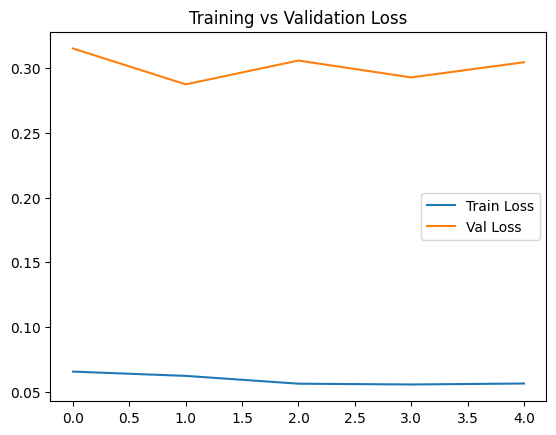

In [18]:
# Evaluate on test set
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test Accuracy: {test_acc:.4f}")

# Accuracy curve
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title("Training vs Validation Accuracy")
plt.savefig("mobilenetv2_accuracy.png")
plt.clf()

# Loss curve
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Training vs Validation Loss")
plt.savefig("mobilenetv2_loss.png")


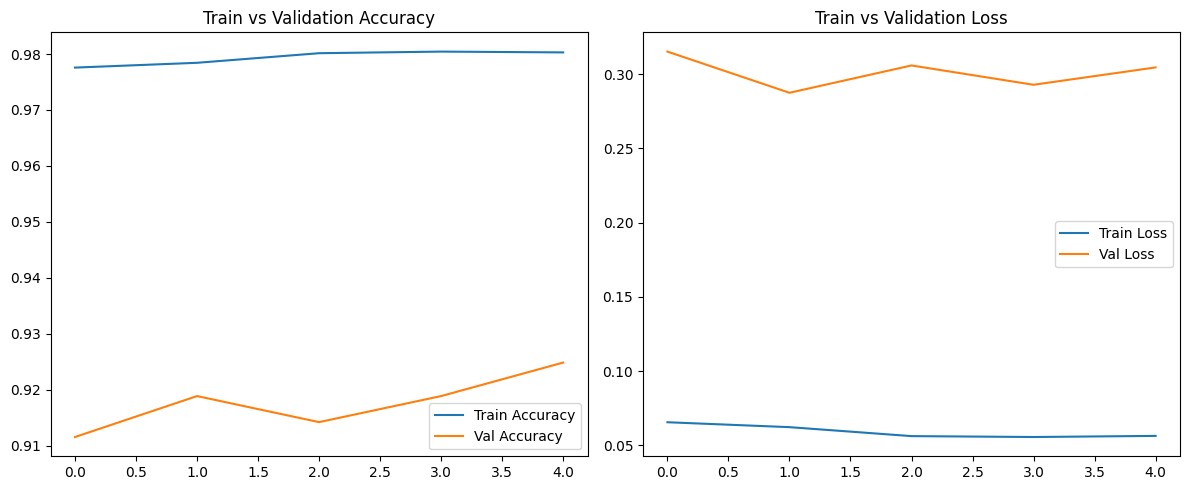

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

# Plot and save
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Accuracy')
plt.plot(epochs_range, val_acc, label='Val Accuracy')
plt.title('Train vs Validation Accuracy')
plt.legend()
plt.savefig("accuracy_curve.png")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Loss')
plt.plot(epochs_range, val_loss, label='Val Loss')
plt.title('Train vs Validation Loss')
plt.legend()
plt.savefig("loss_curve.png")

plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━

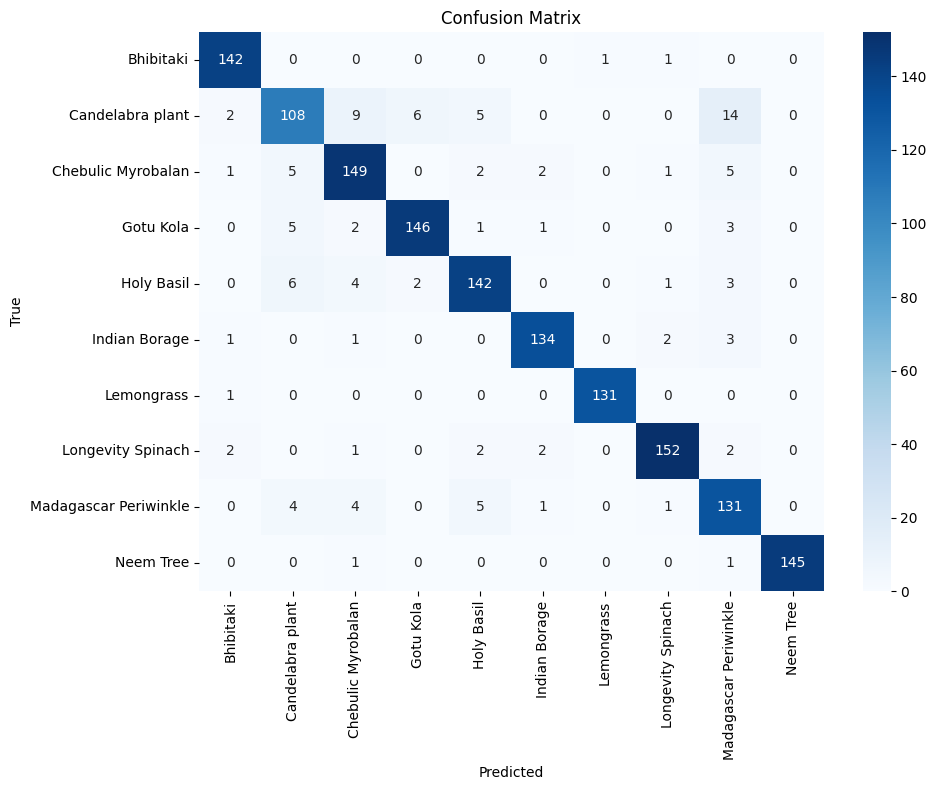

In [20]:
# Get true labels and predicted labels
y_true = []
y_pred = []

for images, labels in test_ds:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Classification report
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot and save confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.savefig("confusion_matrix.png")
plt.show()


In [21]:
# Save Keras model
model.save("mobilenetv2_medicinal_plant.h5")


In [22]:
# Load your trained model
model = tf.keras.models.load_model("mobilenetv2_medicinal_plant.h5")

# Convert to TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model
with open("mobilenetv2_medicinal_plant.tflite", "wb") as f:
    f.write(tflite_model)


Saved artifact at '/tmp/tmpjb8vlgj_'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_layer_1')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  135989340410832: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135989340416976: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135989340421008: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135989340418704: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135989340409872: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135989340409296: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135989340418512: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135989340409680: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135989340410064: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135989340410448: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135989340421

W0000 00:00:1753889735.189923      35 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1753889735.189955      35 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
I0000 00:00:1753889735.330855      35 mlir_graph_optimization_pass.cc:401] MLIR V1 optimization pass is not enabled
